Keras 를 활용해서, kaggle 의 유명한 예제인 Fraud_Detection 을 해보자.


[참고주소 Medium](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)  
[Venelin Valkov github original](https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
## local PC 에서, gpu 메모리를 다른 프로세서가 선점하고 있을때, 다시 설정해주는 코드임
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [4]:
df = pd.read_csv("D:/★2020_ML_DL_Project/Alchemy/dataset/creditcard.csv")

In [5]:
df.shape

(284807, 31)

##### null 값 체크

In [6]:
df.columns.isnull().any()

False

In [7]:
df.isnull().values.any()

False

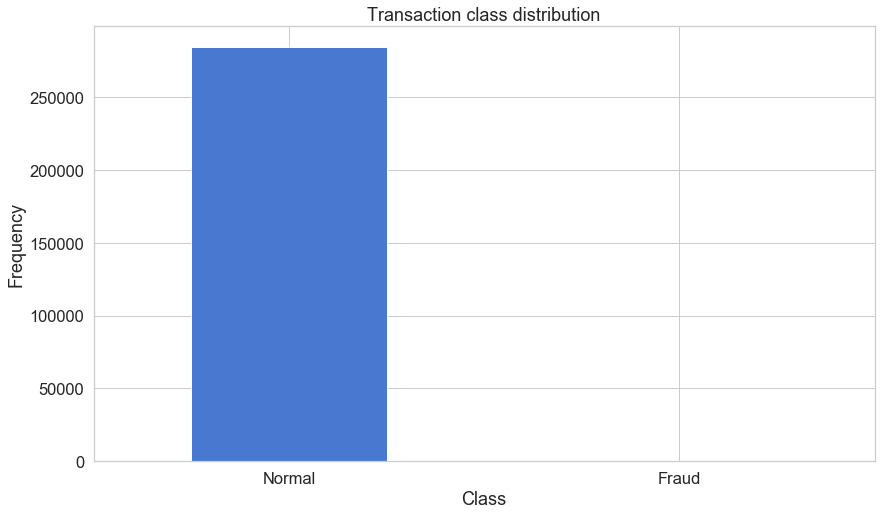

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

전형적인 불균형 imbalanced data 양상을 보이고 있다.
99.9 % vs 0.1 % 임

In [9]:
print(df.Class.value_counts())
print((df.Class.value_counts()/df.Class.count())*100)

0    284315
1       492
Name: Class, dtype: int64
0    99.827251
1     0.172749
Name: Class, dtype: float64


In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

pd.concat([frauds.Amount.describe(),normal.Amount.describe()],axis=1,names=['fraud','normal'])

,Amount,Amount
count,492.000000,284315.000000
mean,122.211321,88.291022
std,256.683288,250.105092
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,2125.870000,25691.160000


데이터는 게다가, 모두 float64 (숫자형데이터)이며, 그중 특이하게 Time 데이터가 있다.

In [11]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [12]:
df.Time.tail()

284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

데이터가 특이해서 찾아보니, 변수 설명이 있었다.
+ Time : Number of seconds elapsed between this transaction and the first transaction in the dataset
> 이 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초)
+ (v1-v28) : may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)

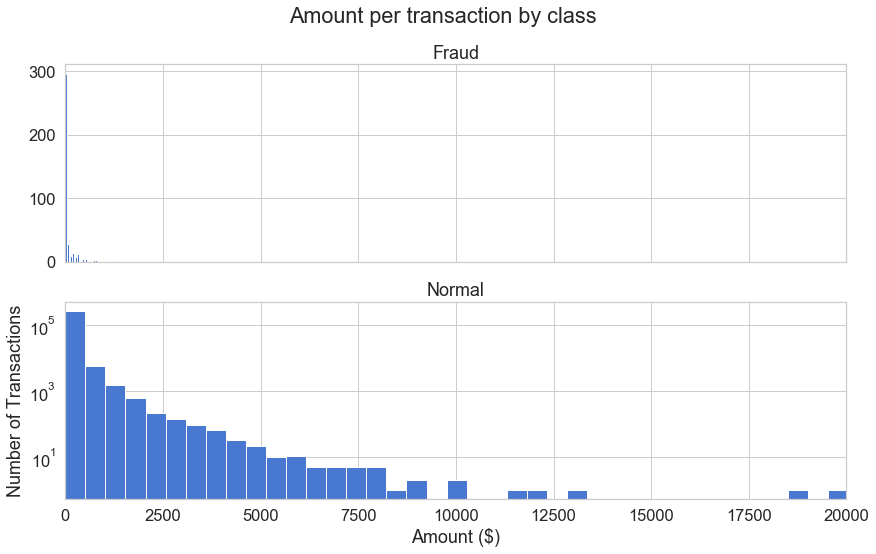

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Fraud 그룹이 발생한 금액대는 대부분 1000 미만의 금액대인것이 보인다.

(0, 1000)

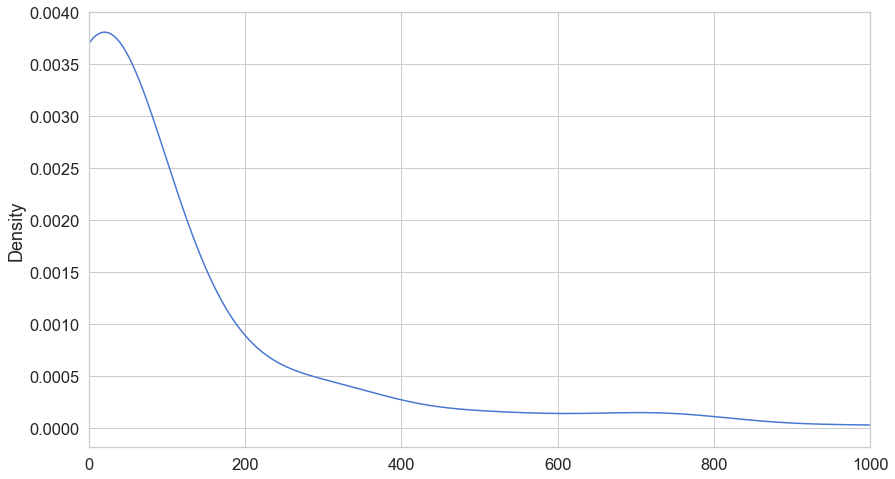

In [14]:
ax=frauds.Amount.plot(kind='kde')
ax.set_xlim(0,1000)

시각화하니, Fraud 건들은 주로 1000건 이하, 특히 400건 이하에서 이루어지고 있음을 알 수 있다.

In [15]:
f1 = lambda x : "{:.4f}".format(x)
frauds.Amount.describe().apply(f1)

count     492.0000
mean      122.2113
std       256.6833
min         0.0000
25%         1.0000
50%         9.2500
75%       105.8900
max      2125.8700
Name: Amount, dtype: object

In [16]:
frauds.Amount.quantile(0.98)

938.0828000000004

In [17]:
normal.Amount.describe().apply(f1)

count    284315.0000
mean         88.2910
std         250.1051
min           0.0000
25%           5.6500
50%          22.0000
75%          77.0500
max       25691.1600
Name: Amount, dtype: object

In [18]:
print(normal.Amount.quantile(0.99)) ## 상위 1% 구간은 1016.966 이다
print(normal.Amount.quantile(0.999))

1016.9663999999966
3000.0


normal 그룹 vs Fraud 그룹 둘다 std 는 250 가량인데, 평균과 중위값이 차이가 있다.
> fraud : mean/중위값  = 122 /9.25  
> normal : mean/중위값 = 88 / 22

둘다 중위값에 비해, 평균값이 크다 -> 분포가 왼쪽 Skewed 가 있다. 오른쪽 꼬리 모양
fraud 가 좀더 편향값이 심하다. 이를 hist 가 아닌 kde 로 재확인해보면,

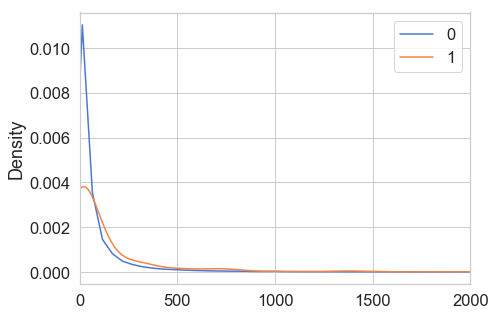

In [19]:
plt.figure(figsize=(7,5))
df.groupby(by=['Class']).Amount.plot(kind='kde',xlim=(0,2000))
plt.legend()

Amount 가 1500 이상이 차지하는 비율을 확인해보면, 1350  row 임. 이중 Fraud 갯수는 3 개 이므로, 이상치로 판단 제거한다. 

In [20]:
print(df.loc[df.Amount >= 1500,:].shape)
print(df.loc[df.Amount >= 1500,'Class'].value_counts())
print(df.loc[df.Amount >= 1500,'Class'].value_counts().iloc[1]/(df.loc[df.Amount >= 1500,:].shape[0])*100)

(1350, 31)
0    1347
1       3
Name: Class, dtype: int64
0.2222222222222222


In [21]:
df01 = df.loc[df.Amount < 1500,:]

df -> df01 로 이상치 제거한 상태에서, 다시 시작

In [22]:
from sklearn.preprocessing import StandardScaler
data = df01.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [23]:
data['Amount'].head()

0    0.473716
1   -0.482156
2    1.963764
3    0.303789
4   -0.044327
Name: Amount, dtype: float64

우리의 목적은 이상거래 탐지인데 여기선, 모델을 정상거래만으로 이루어진걸로 train 시키고, 테스트 세트(20%)에 올바른 클래스를 잡아두면 우리 모델의 성능을 평가할 수 있다. 

In [24]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

In [25]:
## 모두 정상거래인 data
print("X_train.shape",X_train.shape)

X_train.shape (226381, 29)


In [26]:
type(X_train)

pandas.core.frame.DataFrame

In [27]:
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [28]:
## 20% 의 테스트셋에는, 비정상 거래가 들어있다. 대략 0.2 % 가량의 불균형을 보이고 있다
print(y_test.value_counts()) 
print(y_test.value_counts()/y_test.count()*100)

0    56587
1      105
Name: Class, dtype: int64
0    99.814789
1     0.185211
Name: Class, dtype: float64


In [29]:
X_train = X_train.values ## array type 으로 바꾼다. keras DL 에서는 Dataframe을 사용할수 없기때문
X_test = X_test.values

In [30]:
## 0번째 행의 값을 보면 알수 있듯이 PCA로 일단, 어느정도 scaling 이 되어있다고 보고, 원저자는 따로 scale 변환을 안한것 같다.
X_train[0]

array([ 1.0497864 ,  0.13341122,  1.48434448,  2.74270707, -0.83528583,
        0.16557882, -0.504702  ,  0.15437609,  0.10466168,  0.47498457,
       -0.95249838,  0.17203493,  0.0535732 , -0.40718252, -0.29895828,
        0.62560213, -0.41437543, -0.19339594, -0.8548623 , -0.08279022,
       -0.06251716, -0.11457316,  0.01110139,  0.3892984 ,  0.28355026,
       -0.04787002,  0.03551502,  0.04264667, -0.24222819])

In [31]:
print(type(X_train),X_train.shape)

<class 'numpy.ndarray'> (226381, 29)


Keras 모델 만들기 - Autoencoder 모델은 여기선, fully connected layers 로 14-7-7-14 를 이용한다.

#### 함수형 API 로 네트워크 층 만들기  
================__Start__================

In [32]:
input_dim = X_train.shape[1]
## input_layer
input_layer = Input(shape=(input_dim, ))
## Dense_layer first Encoder - 14
encoding_dim = 14
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
## Dense_layer Second Encoder - 7
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
## Dense_layer First Decoder - 7
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
## Dense_layer Second Decoder - 14
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


※ activity_regularizer : keras dense layer의 옵션  
[activity_regularizer](https://keras.io/regularizers/)

#### 함수형 API 로 네트워크 층 만들기  
================__End__================

100 epoch 사용 : 226381 * 100 의 데이터를Train 하는데 사용  
batch_size 32 : 32개씩 묶어서, 1번의 계산을 함. 따라서 1 epoch마다, (226381%%32) 만큼 가중치 갱신이 일어난다.

In [33]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [34]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


Train 상황을 지켜보기 위해, 하기 모듈을 불러와서, 사용한다.  
from keras.callbacks import ModelCheckpoint, TensorBoard

[keras callback 함수 설명](https://keras.io/ko/callbacks/)

In [35]:
## 각 iter 마다, 손실함수 값을 기록함.
checkpointer = ModelCheckpoint(filepath="D:/★2020_ML_DL_Project/Alchemy/DL_Area/model.h5",
                               verbose=0,
                               save_best_only=True)
## 서플로우가 제공하는 시각화 도구입니다.
## 이 콜백은 TensorBoard에 로그를 기록하여 학습과 테스트 측정 항목에 대한 동적 그래프나 모델 내 다양한 레이어에 대한 활성화 히스토그램을 시각화 할 수 있도록 합니다.
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [36]:
history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,
                          shuffle=True,validation_data=(X_test, X_test),verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 226381 samples, validate on 56692 samples
Epoch 1/100
226381/226381 [==============================] - 17s 75us/step - loss: 0.7507 - acc: 0.5925 - val_loss: 0.7385 - val_acc: 0.6488
Epoch 2/100
226381/226381 [==============================] - 16s 73us/step - loss: 0.6889 - acc: 0.6550 - val_loss: 0.7243 - val_acc: 0.6511
Epoch 3/100
226381/226381 [==============================] - 16s 72us/step - loss: 0.6814 - acc: 0.6553 - val_loss: 0.7223 - val_acc: 0.6576
Epoch 4/100
226381/226381 [==============================] - 17s 74us/step - loss: 0.6792 - acc: 0.6566 - val_loss: 0.7190 - val_acc: 0.6548
Epoch 5/100
226381/226381 [==============================] - 17s 73us/step - loss: 0.6780 - acc: 0.6578 - val_loss: 0.7193 - val_acc: 0.6566
Epoch 6/100
226381/226381 [==============================] - 16s 73us/step - loss: 0.6772 - acc: 0.6586 - val_loss: 0.7186 - val_acc: 0.6535
Epoch 7/100
226381/226381 [============================

GPU 가 아닌 상황에서는 꽤나 오래걸린다....callab 으로 할껄 그랬다....로컬PC GPU 는 3G 인데...느리네...10분이상 소요  
val_acc 가 0.7 이상으로 올라가지 않는모습으로 봐서, Callback 함수에서, Early Stopping 을 사용하면 더 좋을 것 같다.  
__EarlyStopping__  
from keras.callbacks import EarlyStopping  
keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=True)

In [ ]:
autoencoder_result = load_model('D:/★2020_ML_DL_Project/Alchemy/DL_Area/model.h5')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

loss 값이 10 회 쯤에서, 떨어지고, 70회쯤에서도 감소한걸 볼 수 있다.  
좀더 상세히 알아보기 위해 , val_data 로 사용했던, X_test 에러값을 살펴보자

In [ ]:
print(X_test.shape)
X_test[0:3,0:5]

In [ ]:
predictions = autoencoder.predict(X_test)

In [ ]:
## 학습이 오래걸리지, 실제 추론 계산은 얼마 안걸림. 좀더 상세히 알아보기 위해
predictions.shape

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
# mse = np.mean(np.sqrt(np.power(X_test - predictions, 2)), axis=1)

In [ ]:
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

In [ ]:
error_df.describe()

In [ ]:
from sklearn.metrics import (recall_score,confusion_matrix,classification_report,roc_curve,roc_auc_score,precision_recall_curve,auc,recall_score,
                             precision_recall_fscore_support)

In [ ]:
error_df.head(3)

In [ ]:
error_df[error_df.true_class==1].head(3)

#### auto_encoder 로 classfy 하는 핵심 아이디어 by cypision 생각  
error_df 의 컨셉은 짐작해보건데, 에러값들은 기본적으로, threshold 이다. 그러니깐, 가장 적절한 threshold 값을 찾고, 이를 통해서, 측정하려는 의도로 보인다.  
지금 keras로 오로지 정상거래 class=0 인것만, train 을 시켰으니, 만약 학습이 완벽하다면,  
class 1에 대해서는 에러값이 class=0 일때보다 훨씬, 두드러지게 클 것이다.  
그래서, mse = np.mean(np.power(X_test - predictions, 2), axis=1) 에 대해서 , sqrt 도 안한것 같다. 나름 좋은 아이디어로 보인다. 참신하다. 진짜.

In [ ]:
## y_score 자리에는 labe 값 뿐아니라, estimate probability 값도 올 수 있다.
fpr, tpr, thresholds = metrics.roc_curve(y_true=error_df.true_class, y_score=error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

In [ ]:
len(thresholds)
print(fpr[0:3],tpr[0:3],thresholds[0:3])

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...  
근데 이 커브 곡선으로 진짜, 모델성능이 좋은지도...그리고, threshold값을 뭘로 해야 하는지도 잘 모르겠다.

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
print(precision.shape)
print(len(precision),len(recall),len(th)) ## th 결과값이 하나 더 적다

[precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

내가 볼때는 대략 threshold 값이 60 일때,  
Precision : 0.74 대략...  
Recall : 0.21 대랙 으로..제일 좋은 시점이 아닌가 싶다. 원저자는 threshold = 2.9 로 했다.

In [ ]:
threshold_00 = 2.9
threshold_01 = 60.0

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_00, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold_00')
ax.hlines(threshold_01, ax.get_xlim()[0], ax.get_xlim()[1], colors="g", zorder=100, label='Threshold_01')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
y_pred = [1 if e > threshold_00 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
target_names = ['normal','fraud']
print(classification_report(error_df.true_class,y_pred,target_names=target_names))

In [ ]:
y_pred = [1 if e > threshold_01 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
target_names = ['normal','fraud']
print(classification_report(error_df.true_class,y_pred,target_names=target_names))

threshold 값을 표현되었지만, 사실 이 값은 reconstruction_error 이다. sqrt 하지 않은 mse 이다. 이 기준값을 threshold 로 하는건데...
(threshold_00 : 원 저자의 threshold vs threshold_01 : cypision(본인) 의 threshold)  
솔직히 왜 원저자는 2.9 로 했는지 모르겠다. 실제 그래프도 내가 실습한거와 비슷한 모양인데. 뭔가 이유가 있을것 같은데..나는 모르겠다.  
일단, 내가 잡은 에러값기준, 60 이 좀더, fraud 기준으로 f1-score 가 더 좋다. 여기까지만이다.

하기는 Keras 의 Sequantial 클래스를 이용하여 모델을 구성한것임 - 참고용

#### Sequatial Class 로 네트워크 층 만들기  
================__Start__================

In [ ]:
from keras import models
from keras import layers

input_dim = X_train.shape[1]
## input_layer
model_S = models.Sequential()
## Dense_layer first Encoder - 14
model_S.add(layers.Dense(14,activation="tanh",activity_regularizer=regularizers.l1(10e-5)))
## Dense_layer Second Encoder - 7
model_S.add(layers.Dense(7,activation="relu"))
## Dense_layer First Decoder - 7
model_S.add(layers.Dense(7,activation='tanh'))
## Dense_layer Second Decoder - 14
model_S.add(layers.Dense(14,activation='relu'))

#### Sequatial Class 로 네트워크 층 만들기  
================__End__================

#### summary
> normal 데이터만을 학습하고, 이를 최적화 시킨다.
> 이제 encoder1-encoder2-decoder1-decoder1  구성으로 loss 함수를 MSE 로 한다. 
> (autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy']))  
> test 데이터나, 실제 데이터가 들어오게 되면, 에러값이 정상데이터보다 훨씬 커지게 출력된다.
> precision, recall 값 들을 시각화하여, 최대로 하는 적절한 에러값을 찾고, 이를 threshold 값으로 정한다. 
> 정해진 threshold 값을 기준으로 classfication 한다. 

※ [통상 auto encoder의 계층모습 : encoder - Latent vector - decoder]  